# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [ ]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output

--2021-01-26 00:31:57--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.007s  

2021-01-26 00:31:57 (29.2 MB/s) - ‘La_noche_estrellada1.jpg’ saved [223725/223725]

--2021-01-26 00:31:57--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) [ima

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import tensorflow as tf


from keras.applications import vgg19
from keras import backend as K
from pathlib import Path
tf.compat.v1.disable_eager_execution()

In [24]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

#base_image_path = "/content/drive/MyDrive/Diplomatura/in/Neckarfront_Tübingen_Mai_2017.jpg"
base_image_path = "/content/drive/MyDrive/Diplomatura/in/foto.jpg"
#style_reference_image_path = "/content/drive/MyDrive/Diplomatura/in/La_noche_estrellada1.jpg"
style_reference_image_path = "/content/drive/MyDrive/Diplomatura/in/picasso.jpg"
result_prefix = "/content/drive/MyDrive/Diplomatura/out"
iterations = 50

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:

El paper renderiza una nueva imagen extrayendo información del contenido y del estilo de otras 2 imágenes proporcionadas.
Para hacer esto aplica gradient descent teniendo en cuenta la siguiente función de Loss:

$\mathit{L}_{total}(\vec{p},\vec{a},\vec{x}) = α  L_{content}(\vec{p},\vec{x}) + β L_{style}(\vec{a},\vec{x})$

Donde:

$\vec{p}$: Imagen de contenido

$\vec{a}$: Imagen de estilo

$\vec{x}$: Imagen a generar

$\alpha$ (content_weight) y $\beta$ (style_weight) funcionan como parametros de ajuste de la función de Loss, haciendo un trade off entre estilo y contenido (permite determinar si la imagen resultante va a tener más información del contenido en detrimento del estilo o viceversa)

Por otro lado, en esta implementación además de las dos componentes nombradas más arriba se agrega un tercer componente que es el Total Variation Loss, una función de regularización que permite resolver problemas con de altas frecuencias en la imagen.

Con lo que nuestra función de Loss quedaría

$\mathit{L}_{total}= \alpha  L_{content} + \beta L_{style} + \gamma L_{total\_variation\_loss}$

El siendo $\gamma$ (total_variation_weight) un parámetro para dar una mayor menor importancia a dicha función de regularización

In [25]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [26]:
load_img(style_reference_image_path).size

(1920, 1080)

In [27]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

Se define una función que lee la imagen y la formatea de la manera requerida.

Primero se carga la imagen y se la transforma a un array, luego con np.expand_dims se le agrega una dimensión al array de la imagen, ya que como viene tiene es un tensor 3d con shape (height, width, depth) y keras requiere un tensor 4d con el batch_size (o cantidad de imágenes, en nuestro caso 1) además de las otras 3 dimensiones, el metodo expand_dims de numpy agrega esta dimensión extra quedando la imagen con un shape (bach_size, height, width, depth).

Por otro lado, vgg19.preprocess_input formatea la imagen como requiere el modelo vgg19. 

Basicamente lo que hace es transformar la imagen de RGB a BGR y luego cada canal de color es zero centred con respecto al dataset de imageNet sin escalar. Esto se hace porque la red vgg19 fue entrenada con imágenes de ese formato y dado q vamos a reutilizar los pesos de ese modelo, necesitamos q nuestra imagen tenga el formato que entiende vgg19


In [29]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

Hace exactamente el proceso inverso anterior, para luego poder visualizar la imagen resultante.

Lo primero que es eliminar la dimensión extra del batch size haciendo un reshape de la imagen, luego elimina el zero centering sumando a cada canal de color la media de cada canal del dataset de imageNet, luego transforma el BGR a RGB y por ultimo deja cada uno de los pixels con intensidad entre 0 y 255.


In [30]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [31]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [32]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [33]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [34]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

La matriz de Gram para un conjunto de vectores { $\vec v_{1}$, $\vec v_{2}$,...,$\vec v_{n}$} es aquella cuyos elementos están formados por el producto punto de cada uno de los vectores:

$G_{ij}$ = <$\vec v_{1}$,$\vec v_{2}$>


En este caso en particular, la matriz de Gram es utilizada para calcular la similitud del estilo. 

Una idea intuitiva del estilo es la correlación entre los diferentes filtros que se le aplica a la imagen, por poner un ejemplo en una foto del cuadro la noche estrellada de Van Gogh se esperaría que el filtro que detecta círculos se active en el mismo sector de la imagen donde se activa el filtro que detecta el color amarillo.

Dado que el producto punto entre dos vectores no es otra cosa que la distancia coseno entre los mismos (lo que da una idea de similitud o cercanía de dichos vectores), la matriz de Gran tiene en cada uno de sus elementos dicha distancia coseno entre las activaciones de cada uno de los filtros:

$G^l_{ij}$ = $\sum_{(k)} F^l_{ik} F^l_{jk}$

Donde $F^l_{ik}$ es la activación del filtro i de la capa l, en la porción k de la imagen y $F^l_{jk}$ es la activación del filtro j de la capa l, en la porción k de la imagen.

La fución de costo que trata de capturar el estilo de la foto, quiere minimizar mide la distancia entre la matriz de Gram de la imagen de estilo y la matriz de Gram de la imagen output.

Es necesario transponer las dimensiones para poder realizar el producto vectorial


In [35]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

###Style Loss:

Se calculan las matrices Gram de la imagen que estamos generando y de la imagen de estilo y luego se calcula el MSE entre ambas matrices.

Cada capa contribuye a la loss total de la siguiente manera:

    
$E_{l} = \frac{1}{4 N_{l}^{2} M_{l}^{2}} \sum_{i,j} (G_{ij}^{l} - A_{ij}^{l})^2$

Donde:

$A^{l}$ : Representación del estilo de la imagen de estilo en la capa l
    
$G^{l}$ : Representación del estilo de la imagen que se está generando en la capa l

$N_{l}$ : Cantidad de filtros

$M_{l}$ : Tamaño del feature map

Luego la Loss de estilo es:

$L_{style}(\vec{a},\vec{x}) = \sum \limits _{l} ^{L} w_{l} E_{l}$

donde $w_{l}$ el el peso relativo que se le da a cada capa que contribuye a estilo.

Lo que quiere mostrar esta loss es la distancia entre las matrices de gram de la imagen de estilo y la imagen que estamos generando. Como ya vimos, las matrices de gram nos dan una especie de correlación entre los filtros, esta correlación es lo que nosotros llamamos estilo, entonces minimizando la distancia entre ambas matrices lo q en verdad hacemos es lograr que ambas imagenes tengan el mismo estilo. Esto se hace principalmente en las primeras capas de la red donde están los filtros q capturan texturas y colores pero no tanto las formas

###Content Loss:

La función de pérdida de contenido viene dada por:
$L_{content}(\vec{p},\vec{x},l) = \frac{1}{2} \sum \limits _{i,j} (F_{ij}^{l} - P_{ij}^{l})^2$

Donde
 
$\vec{p}$: Imagen de contenido

$\vec{x}$: Imagen que se está generando

$P^l_{ij}$: El feature map de la imagen de contenido en la capa l

$F^l_{ij}$: El feature map de la imagen que se está generando

De esta manera la Loss no es otra cosa que el MSE del feature map de ambas imágenes.

En este caso lo que hace esta loss es minimizar la distancia de los diferentes features maps de la imagen de contenido y de la imagen que estamos generando. Haciendolo en las capaz más alejadas de la red podremos capturar el contenido de la imagen de contenido

###Total Variation Loss

Esta función de costo no está definida en el paper sino que se utiliza la implementación dada en https://keras.io/examples/generative/neural_style_transfer/

Este componente de la función de costo es un término de regularización, dado que la suma ponderada de la loss de contenido y de la loss de estilo, genera muchos problemas en sectores de la imagen con frecuencias altas, sobre todo en los bordes.
(https://www.tensorflow.org/tutorials/generative/style_transfer#total_variation_loss)


Combinando todas estas y agregando los pesos vistos en el punto 1, tenemos nuestra función de costo final

$\mathit{L}_{total}= \alpha  L_{content} + \beta L_{style} + \gamma L_{total\_variation\_loss}$



In [36]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [37]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [38]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [39]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [40]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

In [41]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [42]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

Comentario:

Iteración a iteración se va marcando mucho más el estilo, sobre todo parecería ser que las sombras y las tonalidades de la pinturas, van adquiriendo más notoriedad a medida que avanzan las iteraciones.
Las formas de las pinceladas del impresionismo es de las primeras indicios de estilo que el modelo logra transferir.

In [44]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '/' + ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    print(load_img(fname, target_size=(img_nrows, img_ncols)))
    

Start of iteration 0
Current loss value: 28894913000.0
Image saved as /content/drive/MyDrive/Diplomatura/out/output_at_iteration_0.png
Iteration 0 completed in 6s
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=534x400 at 0x7F90A84318D0>
Start of iteration 1
Current loss value: 15736315000.0
Image saved as /content/drive/MyDrive/Diplomatura/out/output_at_iteration_1.png
Iteration 1 completed in 6s
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=534x400 at 0x7F90A8431F98>
Start of iteration 2
Current loss value: 11872037000.0
Image saved as /content/drive/MyDrive/Diplomatura/out/output_at_iteration_2.png
Iteration 2 completed in 6s
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=534x400 at 0x7F90A8431400>
Start of iteration 3
Current loss value: 9963521000.0
Image saved as /content/drive/MyDrive/Diplomatura/out/output_at_iteration_3.png
Iteration 3 completed in 6s
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=534x400 at 0x7F90A83CEAC8>
Start of iteration 4
Current 

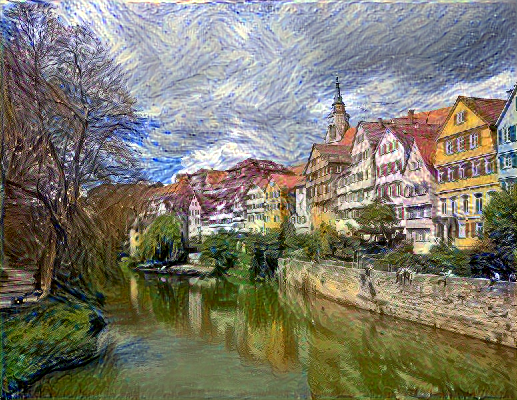

In [ ]:
load_img(fname)

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta: